<a href="https://colab.research.google.com/github/kcwanglucky/filetransfer/blob/master/app_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Provide "/content/20190508起APP評論.xlsx" or whatever app comment file with similar format

In [0]:
!git clone https://github.com/kcwanglucky/BertSequenceClassification_streamline.git

Cloning into 'BertSequenceClassification_streamline'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 173 (delta 3), reused 7 (delta 2), pack-reused 164
Receiving objects: 100% (173/173), 79.39 KiB | 846.00 KiB/s, done.
Resolving deltas: 100% (104/104), done.


In [0]:
!pip install transformers

     |████████████████████████████████| 665kB 6.3MB/s 
     |████████████████████████████████| 1.1MB 40.0MB/s 
     |████████████████████████████████| 3.8MB 49.8MB/s 
     |████████████████████████████████| 890kB 43.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b4b3b59c32e49ae1db616a725ebca35970c6cc4eec03f4bce8b96feffd455739
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Idea:
1.   13 reponses with > 5 counts automatically form groups. Try to put the other 129 types into the aforementioned 13 groups if certain conditions meet (consine similarity of Bert embeddings, etc.). If not, put into a separate group.

    > Result:
        *   Directly assigned to the group with highest cossim: 60ep - train acc~ 99%, test acc~ 45%
        *   If max consim < 98.5%, create a separate group: 60ep - train acc~ 98.4%, test acc~ 44%
        *   dropna the "index" and "question" columns:  
        1) 15ep - train acc~ 98%, test acc~ 73% (ep15_eg5_ml30)  
        2) 35ep - train acc~ 99%, test acc~ 65% (param: ep35_eg5_ml50)  
        3) model_ep20_eg0_ml40 - train acc~ 99%, test acc~ 63%  
        4) model_ep25_eg5_ml30 - train acc~ 99%, test acc~ 72.3%  
        5) model_ep25_eg0_ml30 - train acc~ 99%, test acc~ 66%  
        6) model_ep25_eg0_ml50 - train acc~ 98%, test acc~ 68%  
        7) model_ep25_eg5_ml30 - train acc~ 99%, test acc~ 71.5%  
        




2.   Do a binary classification first based on sentiment (稱讚 vs 抱怨) Then build a bert multilabel classifier as usual

    > Result:
        *   Step 1 (Binary):  
        model_ep25_eg0_ml50 - Train acc: 99.9% Test accuracy: 98.59%  
            -> 目前的 dataset 已能蠻正確分類出稱讚的評論  
        *   Step 2 (Multiclass):  
        model_ep25_eg0_ml50 - Train acc: 98% Test accuracy: 53%  
            -> 爛在這QQ








In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from BertSequenceClassification_streamline.bert_downstream_classification import *

In [0]:
def let_colab_print_chinese():
    """Download the required font to print chinese characters on plots created by matplotlib
    Returns:
        FontProperties: when provide it as an argument to plt.plot graphs,
                        chinese character can be displayed
    """
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
    !unzip "NotoSansCJKkr-hinted.zip"
    !mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/
    path = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
    fontprop = fm.FontProperties(fname=path, size= 12)
    return fontprop

In [0]:
def preprocess_app_comment(path, verbose = False):
    """讀取 app comment
    Args:
        path (str): path to the app comment file
        verbose (int): If True, print 各類別對應的筆數
    Returns:
        DataFrame: The DataFrame with only relevant data
    """
    df_all = pd.read_excel(path)
    df_all.rename(columns={"評論內容": "question", "類別": "index"}, inplace = True)
    df_all.dropna(axis = 0, how = 'any', subset=["question", "index"], inplace = True)
    df_all.to_csv("all_app_comment.csv")
    if verbose:
        print(df_all['index'].value_counts())
    return df_all

In [0]:
"""得到此 dataframe 的訓練分布 (分類:筆數)
   df: "pd.DataFrame" type
"""
def get_dist(df, index2label, verbose = False):
    each_count = df['index'].value_counts()
    if verbose:
        print("所有 data 各類分布: \n")
        for index in each_count.index:
            print("{:15} 數量: {}".format(index, each_count[index] ))
    return each_count

In [0]:
"""得到此 dataset 的訓練分布 (分類:筆數)
   dataset: "Dataset" type
"""
def get_dataset_dist(mode, dataset, index2label, verbose = False):
    def get_index2label(i):
        return index2label[i]
    index_list = dataset.df['index'].apply(get_index2label) 

    each_count = index_list .value_counts()
    if verbose:
        print(mode + "set 各類分布: \n")
        for idx in each_count.index:
            print("{:15} 數量: {}".format(index2label[idx], each_count[idx] ))
    return each_count 

In [0]:
def plot_pie(mode, dist):
    plt.figure(figsize=(10, 10), facecolor="w")
    plt.title("{}set Distribution ({} data)".format(mode, sum(dist)), fontsize=16)
    patches, l_text, p_text = plt.pie(dist, autopct="%1.1f%%",
                                    textprops = {"fontsize" : 12}, labeldistance=1.05)
    for i, t in enumerate(l_text): 
        t.set_text(dist.index[i])
        t.set_fontproperties(fontprop)
        #t.set_color('red')
        pct = float(p_text[i].get_text().strip('%'))
        #print(pct)
        if pct < 0.8:
            p_text[i].set_text("")
            l_text[i].set_text("")
        #p_text[i].set_color('red')
    # 把每個文字設成中文字型
    plt.show()

In [0]:
# 為了讓 colab 能 print 中文
fontprop = let_colab_print_chinese()
#fm.FontProperties(fname='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', size= 12)

--2020-05-24 17:30:58--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c0c::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  45.1MB/s    in 2.6s    

2020-05-24 17:31:02 (45.1 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Thi

In [0]:
"""set the arguments if not using a command line """
class Args:
    #data_path = 'all_app_comment.csv'
    epoch = 25
    batch_size = 64
    min_each_group = 0                     # 每組至少要有幾筆才被放入訓練集
    maxlength = 1000                          # 若app comment評論超過此長度則刪除
    model_output = 'model_ep25_eg5_ml50'
    #model_start = "app_all1"
args = Args()

In [0]:
df1 = pd.read_excel("20190508起APP評論.xlsx")
#preprocess_app_comment("20190508起APP評論.xlsx")

In [0]:
len(df1)

2163

In [0]:
df1 = df1.loc[:, ["index", "question"]]  

In [0]:
long_question_idx = [len(question) > 50 for question in df1['question']]

In [0]:
df1[long_question_idx].iloc[2]

index                                                    未知問題
question    這個程式太不人性化第一次使用者一定要先至電腦進入注冊完成之才能選行手機設定(注冊)在手機A ...
Name: 54, dtype: object

In [0]:
len(df)

1742

In [0]:
df = preprocess_app_comment("20190508起APP評論.xlsx")
df = df.loc[:, ["index", "question"]]       # get 'index' and 'question' coluumn
df = filter_toofew_toolong(df, args.min_each_group, args.maxlength)
index = df['index']
index2label = {idx:val for idx, val in enumerate(index.unique())}
num_index = len(index2label)

In [0]:
data_dist = get_dist(df, index2label)

31.3
26.0
11.5
8.9
5.4
4.6
4.1
2.7
2.3
1.7
0.9
0.2
0.1
0.1


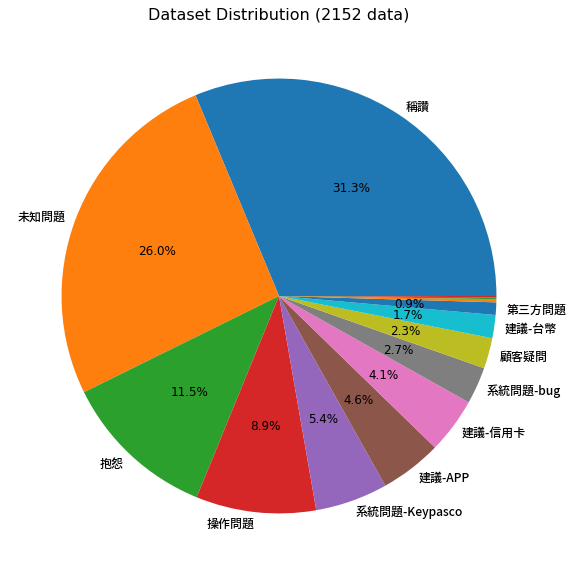

In [0]:
plot_pie("Data", data_dist)

由於 “第三方問題” “建議-台幣” “顧客疑慮” 筆數過少，利用設 "args.min_each_group" 參數來將之排除在分類器的訓練集裡。若將來有更多資料，就可重新放入訓練

In [0]:
"""預備訓練模型""" 
def get_dataloader_numlabels(df, min_each_group, maxlength, batch_size):
    
    df, NUM_LABELS = preprocessing(df, min_each_group, maxlength)   # preprocessed

    df_train, df_val, df_test = output_split(df, 0.7)

    PRETRAINED_MODEL_NAME = "bert-base-chinese"
    # 取得此預訓練模型所使用的 tokenizer
    tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
    clear_output()

    # 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞
    trainset = getOnlineQueryDataset("train", df_train, tokenizer)
    valset = getOnlineQueryDataset("val", df_val, tokenizer)
    testset = getOnlineQueryDataset("test", df_test, tokenizer)

    # 初始化一個每次回傳 64 個訓練樣本的 DataLoader
    # 利用 collate_fn 將 list of samples 合併成一個 mini-batch
    BATCH_SIZE = batch_size
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  
                            collate_fn=create_mini_batch)
    valloader = DataLoader(valset, batch_size=BATCH_SIZE,  
                            collate_fn=create_mini_batch)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, 
                        collate_fn=create_mini_batch)
    return trainset, valset, testset, trainloader, valloader, testloader, NUM_LABELS

In [0]:
trainset, valset, testset, trainloader, valloader, testloader, NUM_LABELS = \
get_dataloader_numlabels(df, args.min_each_group, args.maxlength, args.batch_size)

In [0]:
train_dist = get_dataset_dist("train", trainset, index2label)
val_dist = get_dataset_dist("val", valset, index2label)
test_dist = get_dataset_dist("test", testset, index2label)

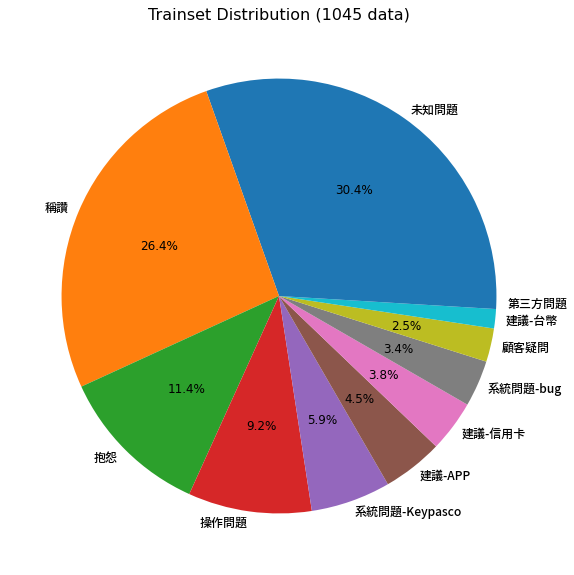

In [0]:
plot_pie("Train", train_dist)

訓練集的設計是要讓各類的比例與實際 dataset 一樣

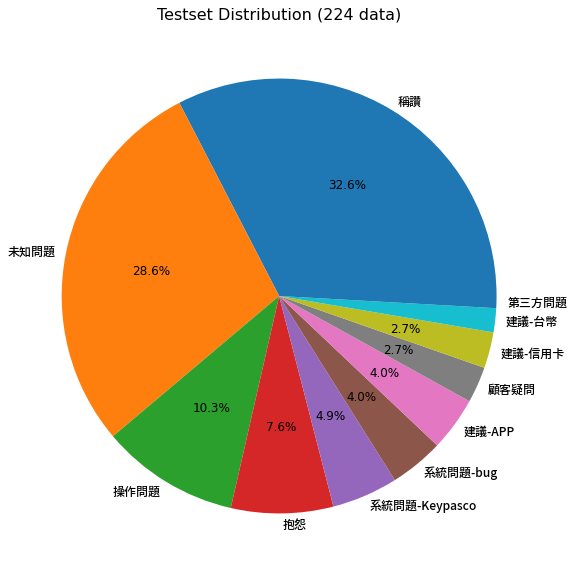

In [0]:
plot_pie("Test", test_dist)

In [0]:
# if args.model_start:    # If model_start is provided, then initialize model with the existing model
#     PRETRAINED_MODEL_NAME = args.model_start
PRETRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

model = train(trainloader, valloader, PRETRAINED_MODEL_NAME, NUM_LABELS, args.epoch)
save_model(args, args.model_output, model, tokenizer)

predictions = get_predictions(model, testloader).detach().cpu().numpy()

# if args.model_prediction:
#     write_prediction(args.model_prediction, predictions)

# if 'index' in testset.df:      # If we have labels on test set, we can calculate the accuracy
#     # 用分類模型預測測試集
#     test_label = testset.df['index']
#     print("Testset accuracy: %f" % plain_accuracy(test_label, predictions))


device: cuda:0

======== Epoch 1 / 25 ========
Training...
loss: 39.883, acc: 0.448

Running Validation...
  Accuracy: 0.43

======== Epoch 2 / 25 ========
Training...
loss: 30.826, acc: 0.541

Running Validation...
  Accuracy: 0.51

======== Epoch 3 / 25 ========
Training...
loss: 26.111, acc: 0.600

Running Validation...
  Accuracy: 0.58

======== Epoch 4 / 25 ========
Training...
loss: 22.713, acc: 0.639

Running Validation...
  Accuracy: 0.59

======== Epoch 5 / 25 ========
Training...
loss: 19.947, acc: 0.697

Running Validation...
  Accuracy: 0.62

======== Epoch 6 / 25 ========
Training...
loss: 17.126, acc: 0.733

Running Validation...
  Accuracy: 0.60

======== Epoch 7 / 25 ========
Training...
loss: 15.276, acc: 0.783

Running Validation...
  Accuracy: 0.61

======== Epoch 8 / 25 ========
Training...
loss: 13.127, acc: 0.804

Running Validation...
  Accuracy: 0.60

======== Epoch 9 / 25 ========
Training...
loss: 11.296, acc: 0.850

Running Validation...
  Accuracy: 0.64

===

Create a gruop-to-group comparison matrix

In [0]:
def get_confusion_matrix(true_label, predictions, num_index):
    class_matrix = np.zeros(shape=(num_index ,num_index))
    false_group = [[] for _ in range(num_index)]
    for idx, true, pred in zip(range(len(predictions)),true_label, predictions):
        class_matrix[true][pred] += 1
        if true != pred:
            false_group[true].append(idx)
    return class_matrix, false_group
true_label = testset.df["index"]
class_matrix, false_group = get_confusion_matrix(true_label, predictions, num_index)

In [0]:
def print_acc(class_matrix):
    total = 0
    for i in range(num_index):
        total += class_matrix[i][i]
    print("Accuracy: {0}%".format(100 * total/np.sum(class_matrix)))
print_acc(class_matrix)

Accuracy: 70.53571428571429%


In [0]:
label_list = [index2label[key] for key in index2label]
label2index = {val:key for key, val in index2label.items()}
summary = pd.DataFrame(class_matrix, dtype = int, columns=label_list, index = label_list )
print("測試集 confusion matrix:")
summary

測試集 confusion matrix:


,未知問題,稱讚,操作問題,抱怨,建議-台幣,建議-信用卡,第三方問題,建議-APP,顧客疑問,系統問題-bug,系統問題-Keypasco
未知問題,46,2,8,3,0,0,0,0,1,0,4
稱讚,2,67,0,2,0,1,0,0,0,0,1
操作問題,5,3,9,4,0,0,0,1,0,1,0
抱怨,1,0,3,13,0,0,0,0,0,0,0
建議-台幣,0,0,1,0,1,1,0,1,0,0,0
建議-信用卡,0,0,1,0,0,5,0,0,0,0,0
第三方問題,1,0,1,0,0,0,0,0,0,0,0
建議-APP,0,0,2,0,0,0,0,6,1,0,0
顧客疑問,3,0,1,0,0,0,0,0,1,0,1
系統問題-bug,2,0,1,1,0,0,0,0,0,5,0


上表的左邊是客服標的正確分類，右邊是分類器所做的分類

> 1. 大致上來說，稱讚類的問題幾乎都能被正確歸類到稱讚，也就是說我們針對稱讚類問題應該能蠻準確的回覆  
2. 蠻多問題會被錯誤的分類到 ”未知問題“ 與 “操作問題” 兩個組別（看 ”未知問題“ 與 “操作問題” 兩欄的分佈） 
3. “抱怨” 及 “操作問題” 類問題被分到許多不同的組別（看 ”抱怨” 與 “操作問題” 那兩橫列 的分佈） 
4. 整體而言，“操作問題” 及 “抱怨” 兩類似乎問題較大。若能增加其他分類的資料量的話能對整個分類器的準確率有所幫助





In [0]:
"""print 出第 i 組的分類概覽
   包括所有此類的問題， 被錯誤分類成哪個組別
"""
def print_summary_i(i, class_matrix, index2label, false_group, topK = 3):
    num_each_group = np.sum(class_matrix, axis = 1)
    num_group = np.sum(class_matrix[i])
    print("類別: {0} \t 測試集筆數: {1}".format(index2label[i], int(num_group)))
    print("正確分類筆數: {0}".format(class_matrix[i][i]))
    print("被分類器正確分類的機率: {0} %".format(100 * class_matrix[i][i]/num_each_group[i]) )
    sorted_idxs = np.argsort(class_matrix[i])
    if sorted_idxs[-1] == i:
        idx = sorted_idxs[-2]
    else:
        idx = sorted_idxs[-1]
    
    if class_matrix[i][idx] != 0:
        print("最常被分錯的組別: {0}  筆數: {1}".format(index2label[idx], class_matrix[i][idx]) )
        count = 0
        for f in false_group[i]:
            if count >= topK: break
            print("example: ")
            print(testset.df.iloc[f]['question'])
            print("-> 被分成: {0}".format(index2label[ predictions[f] ] ))
            count += 1
    print("")

In [0]:
"""畫出第 i 組評論的分類分佈"""
def plot_group_i(i, class_matrix):
    num_each_group = np.sum(class_matrix, axis = 1)
    plt.figure(figsize = (10, 5), facecolor="w")
    y_value = np.array(class_matrix[i], dtype = int)
    plt.bar(range(num_index), height = y_value)
    #plt.xticks(range(num_index),('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'))
    plt.xticks(range(num_index), label_list, fontproperties=fontprop)
    plt.title("原始組別: " + label_list[i], fontproperties=fontprop)
    plt.xticks(rotation=270, fontproperties=fontprop)
    plt.xlabel("被分類的組別", fontproperties=fontprop)
    for j in range(num_index):
        perc = round(100 * y_value[j]/num_each_group[i], 2)
        plt.text(j - 0.4, y_value[j], str(perc) + "%", color='blue', fontproperties=fontprop)
    #plt.subplot(432)
    plt.show()

個別檢查

In [0]:
for i in range(num_index):
    print_summary_i(i, class_matrix, index2label, false_group, topK = 3)

類別: 未知問題 	 測試集筆數: 64
正確分類筆數: 46.0
被分類器正確分類的機率: 71.875 %
最常被分錯的組別: 操作問題  筆數: 8.0
example: 
存摺備註
-> 被分成: 稱讚
example: 
請問我在貴公司辦了2張信用卡，能同時亮出2張卡額度嗎？
-> 被分成: 顧客疑問
example: 
請問為什麼現在我的圖型設定一直無法成功呢？每次設定好了，回到主頁面又顯示要設定圖形的頁面。
-> 被分成: 系統問題-Keypasco

類別: 稱讚 	 測試集筆數: 73
正確分類筆數: 67.0
被分類器正確分類的機率: 91.78082191780823 %
最常被分錯的組別: 抱怨  筆數: 2.0
example: 
希望有第二張以上的信用卡，可以記錄消費資訊，現在app裡只能顯示一張信用卡
-> 被分成: 建議-信用卡
example: 
今天開始，無法使用快速登入，一直顯示“連線安全檢查”，只能使用帳號登入。(調整星等)
-> 被分成: 未知問題
example: 
無超商繳費條碼不方便，也有人反應就是不改。(調整星等1>4)
-> 被分成: 抱怨

類別: 操作問題 	 測試集筆數: 23
正確分類筆數: 9.0
被分類器正確分類的機率: 39.130434782608695 %
最常被分錯的組別: 未知問題  筆數: 5.0
example: 
別家銀行網路銀行申請清鬆簡單 就你們玉山難以完成綁定！⋯試過N次⋯最後放棄！一顆星都不想給！
-> 被分成: 抱怨
example: 
Android WebView這個版本已停用
-> 被分成: 未知問題
example: 
網路匯個款，傳給簡訊也等太久了吧
-> 被分成: 抱怨

類別: 抱怨 	 測試集筆數: 17
正確分類筆數: 13.0
被分類器正確分類的機率: 76.47058823529412 %
最常被分錯的組別: 操作問題  筆數: 3.0
example: 
居然加了越獄偵測還無法使用，實在無知擾民。
-> 被分成: 操作問題
example: 
未出帳紀錄和可用額度應各卡分開，混在一起都不知道哪張卡剩下多少額度可用，相當困擾
-> 被分成: 操作問題
example: 
誰家的市話電話有8碼？全都檢核異常，不給線上申請還做這app幹麻
-> 被分成: 操作

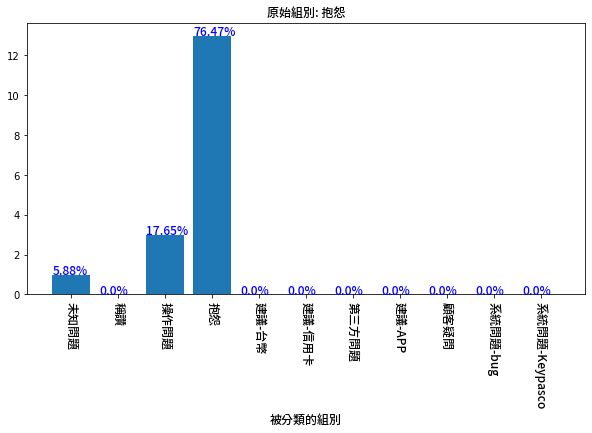

In [0]:
# labels: ('未知問題','操作問題','稱讚','建議-台幣','抱怨','建議-信用卡','建議-APP','顧客疑問','系統問題-bug','第三方問題','系統問題-Keypasco')
i = label2index['抱怨']
plot_group_i(i, class_matrix)

In [0]:
print_summary_i(i, class_matrix, index2label, false_group, topK = 5)

類別: 抱怨 	 測試集筆數: 17
正確分類筆數: 13.0
被分類器正確分類的機率: 76.47058823529412 %
最常被分錯的組別: 操作問題  筆數: 3.0
example: 
居然加了越獄偵測還無法使用，實在無知擾民。
-> 被分成: 操作問題
example: 
未出帳紀錄和可用額度應各卡分開，混在一起都不知道哪張卡剩下多少額度可用，相當困擾
-> 被分成: 操作問題
example: 
誰家的市話電話有8碼？全都檢核異常，不給線上申請還做這app幹麻
-> 被分成: 操作問題
example: 
建議方式完全無效
-> 被分成: 未知問題



## Approach 2: Binary calssification followed by a multiclass classification on non-compliment comments

(1) Binary calssification (分出稱讚以及非稱讚的評論)

In [0]:
# df = preprocess_app_comment("20190508起APP評論.xlsx")
# df = df.loc[:, ["index", "question"]]       # get 'index' and 'question' coluumn
# df = filter_toofew_toolong(df, args.min_each_group, args.maxlength)
df_binary = df.copy()
df_binary['index'] = df_binary['index'].apply(lambda x: 1 if x == '稱讚' else 0)
index = df_binary['index']
index2label = {idx:val for idx, val in enumerate(index.unique())}
num_index = len(index2label)

In [0]:
trainset, valset, testset, trainloader, valloader, testloader, NUM_LABELS = \
get_dataloader_numlabels(df_binary, args.min_each_group, args.maxlength, args.batch_size)

In [0]:
train_dist = get_dataset_dist("train", trainset, index2label)
val_dist = get_dataset_dist("val", valset, index2label)
test_dist = get_dataset_dist("test", testset, index2label)

In [0]:
# if args.model_start:    # If model_start is provided, then initialize model with the existing model
#     PRETRAINED_MODEL_NAME = args.model_start
model = train(trainloader, valloader, PRETRAINED_MODEL_NAME, NUM_LABELS, args.epoch)
save_model(args, args.model_output+"bin", model, tokenizer)

predictions = get_predictions(model, testloader).detach().cpu().numpy()

device: cuda:0

======== Epoch 1 / 25 ========
Training...
loss: 7.957, acc: 0.848

Running Validation...
  Accuracy: 0.82

======== Epoch 2 / 25 ========
Training...
loss: 4.471, acc: 0.953

Running Validation...
  Accuracy: 0.90

======== Epoch 3 / 25 ========
Training...
loss: 2.663, acc: 0.973

Running Validation...
  Accuracy: 0.94

======== Epoch 4 / 25 ========
Training...
loss: 1.764, acc: 0.984

Running Validation...
  Accuracy: 0.94

======== Epoch 5 / 25 ========
Training...
loss: 1.036, acc: 0.989

Running Validation...
  Accuracy: 0.95

======== Epoch 6 / 25 ========
Training...
loss: 0.686, acc: 0.993

Running Validation...
  Accuracy: 0.94

======== Epoch 7 / 25 ========
Training...
loss: 0.535, acc: 0.994

Running Validation...
  Accuracy: 0.95

======== Epoch 8 / 25 ========
Training...
loss: 0.447, acc: 0.993

Running Validation...
  Accuracy: 0.95

======== Epoch 9 / 25 ========
Training...
loss: 0.350, acc: 0.995

Running Validation...
  Accuracy: 0.94

======== Epo

In [0]:
true_label = testset.df["index"]
class_matrix, false_group = get_confusion_matrix(true_label, predictions, num_index)

In [0]:
print_acc(class_matrix)

Accuracy: 97.30941704035874%


In [0]:
for i in range(num_index):
    print_summary_i(i, class_matrix, index2label, false_group, topK = 10)

類別: 0 	 測試集筆數: 170
正確分類筆數: 168.0
被分類器正確分類的機率: 98.82352941176471 %
最常被分錯的組別: 1  筆數: 2.0
example: 
gidaben10051985
-> 被分成: 1
example: 
0975023填單
-> 被分成: 1

類別: 1 	 測試集筆數: 53
正確分類筆數: 49.0
被分類器正確分類的機率: 92.45283018867924 %
最常被分錯的組別: 0  筆數: 4.0
example: 
更新後卡頓嚴重，有時根本開不了，我是I712.2版本，重新卸載後關機重新安裝以後有好點了
-> 被分成: 0
example: 

原來要先設定圖形才能設定指紋辨識
-> 被分成: 0
example: 
Very good
-> 被分成: 0
example: 
圖形驗證不適用Android 7.0，希望能儘快更新。
*僅調整星等1→4(如附圖)
-> 被分成: 0





> 能瞞準確地辨別出稱讚類評論



In [0]:
label_list = [index2label[key] for key in index2label]
label2index = {val:key for key, val in index2label.items()}
summary = pd.DataFrame(class_matrix, dtype = int, columns=label_list, index = label_list )
print("測試集 confusion matrix:")
summary

測試集 confusion matrix:


,0,1
0,168,2
1,4,49


(2) Multiclass classification on non-compliment comments.

In [0]:
# df = preprocess_app_comment("20190508起APP評論.xlsx")
# df = df.loc[:, ["index", "question"]]       # get 'index' and 'question' coluumn
# df = filter_toofew_toolong(df, args.min_each_group, args.maxlength)
df_other = df.copy()
df_other = df_other[df_other['index'] != '稱讚']
index = df_other['index']
index2label = {idx:val for idx, val in enumerate(index.unique())}
num_index = len(index2label)

In [0]:
trainset, valset, testset, trainloader, valloader, testloader, NUM_LABELS = \
get_dataloader_numlabels(df_other, args.min_each_group, args.maxlength, args.batch_size)

In [0]:
train_dist = get_dataset_dist("train", trainset, index2label)
val_dist = get_dataset_dist("val", valset, index2label)
test_dist = get_dataset_dist("test", testset, index2label)

In [0]:
# if args.model_start:    # If model_start is provided, then initialize model with the existing model
#     PRETRAINED_MODEL_NAME = args.model_start
model = train(trainloader, valloader, PRETRAINED_MODEL_NAME, NUM_LABELS, args.epoch)
save_model(args, args.model_output+"other", model, tokenizer)

predictions = get_predictions(model, testloader).detach().cpu().numpy()

device: cuda:0

======== Epoch 1 / 25 ========
Training...
loss: 28.392, acc: 0.391

Running Validation...
  Accuracy: 0.36

======== Epoch 2 / 25 ========
Training...
loss: 24.884, acc: 0.424

Running Validation...
  Accuracy: 0.39

======== Epoch 3 / 25 ========
Training...
loss: 22.426, acc: 0.454

Running Validation...
  Accuracy: 0.41

======== Epoch 4 / 25 ========
Training...
loss: 20.796, acc: 0.530

Running Validation...
  Accuracy: 0.45

======== Epoch 5 / 25 ========
Training...
loss: 19.198, acc: 0.571

Running Validation...
  Accuracy: 0.47

======== Epoch 6 / 25 ========
Training...
loss: 17.694, acc: 0.618

Running Validation...
  Accuracy: 0.50

======== Epoch 7 / 25 ========
Training...
loss: 16.076, acc: 0.668

Running Validation...
  Accuracy: 0.54

======== Epoch 8 / 25 ========
Training...
loss: 14.753, acc: 0.730

Running Validation...
  Accuracy: 0.54

======== Epoch 9 / 25 ========
Training...
loss: 13.335, acc: 0.768

Running Validation...
  Accuracy: 0.54

===

In [0]:
true_label = testset.df["index"]
class_matrix, false_group = get_confusion_matrix(true_label, predictions, num_index)
print_acc(class_matrix)

Accuracy: 48.4472049689441%


In [0]:
label_list = [index2label[key] for key in index2label]
label2index = {val:key for key, val in index2label.items()}
summary = pd.DataFrame(class_matrix, dtype = int, columns=label_list, index = label_list )
print("測試集 confusion matrix:")
summary

測試集 confusion matrix:


,未知問題,操作問題,抱怨,建議-台幣,建議-信用卡,第三方問題,建議-APP,顧客疑問,系統問題-bug,系統問題-Keypasco
未知問題,44,5,6,0,1,0,1,7,0,4
操作問題,5,2,4,0,1,1,3,3,0,2
抱怨,7,4,12,0,0,0,0,0,0,0
建議-台幣,0,0,0,1,0,0,1,0,0,0
建議-信用卡,0,0,0,0,6,0,0,2,0,0
第三方問題,2,1,0,0,0,0,0,0,0,0
建議-APP,1,1,2,0,0,0,6,2,0,0
顧客疑問,0,2,3,0,0,0,0,0,0,0
系統問題-bug,0,1,0,0,0,0,0,0,5,0
系統問題-Keypasco,7,2,2,0,0,0,0,0,0,2


### Read the mapping

In [0]:
df_map = pd.read_excel("公版評論回覆與分類表@20200313.xlsx")

In [0]:
df_map[['子分類', '公版內容']]

,子分類,公版內容
0,建議,親愛的顧客您好\n感謝您的支持與愛護，本行將持續改善與精進，我們會把您的意見回饋給相關單位，...
1,NaN,親愛的顧客您好\n感謝您的回饋，建議您可以先使用電腦登入網路銀行，點選「XXXX」→XXXX...
2,NaN,"Dear Customer,\nThank you for your feedback. ..."
3,抱怨,親愛的顧客您好\n造成您的不便，敬請見諒。本行將持續改善與精進，我們會把您的意見回饋給相關單...
4,抱怨,親愛的顧客您好\n感謝您的回饋，建議您亦可使用智能客服(https://robot.esun...
5,未知問題,親愛的顧客您好\n感謝您的回饋，為了進一步確認您的問題，以便把您的意見回饋給相關單位，請您使...
6,稱讚,親愛的顧客您好\n您的支持與愛護是玉山服務更精進的動力。謝謝您~
7,NaN,親愛的顧客您好\n感謝您給予5顆星~您的支持與愛護是玉山服務更精進的動力。謝謝您~
8,操作問題,親愛的顧客您好\n感謝您的回饋，本行已提供超商條碼繳費服務，敬請將APP更新至最新版後使用。...
9,NaN,親愛的顧客您好\n請您確認：\n(1) 行動裝置是否支援指紋辨識功能。\n(2) Andro...


In [0]:
curr = ""
subclass = []
for i in range(len(df_map)):
    string = df_map.loc[i, '子分類']
    if string is not np.nan:
        curr = string
    subclass.append(curr)

In [0]:
df_map['子分類'] = subclass

In [0]:
len(df_map)

59